In [ ]:
import os
import warnings
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Carregando Modelo

In [ ]:
faizalkarim_flood_area_segmentation_path = kagglehub.dataset_download('faizalkarim/flood-area-segmentation')
base_dir='/kaggle/input/flood-area-segmentation'
print('Images: ', len(os.listdir(os.path.join(base_dir,'Image'))))
print('Masks: ',len(os.listdir(os.path.join(base_dir,'Mask'))))

image_dir = os.path.join(base_dir, 'Image')
mask_dir = os.path.join(base_dir, 'Mask')

Images:  290
Masks:  290


## Visualização

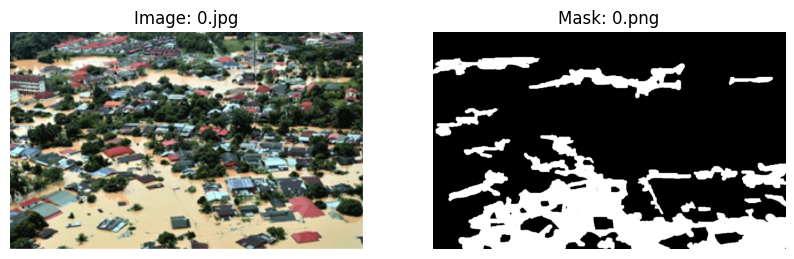

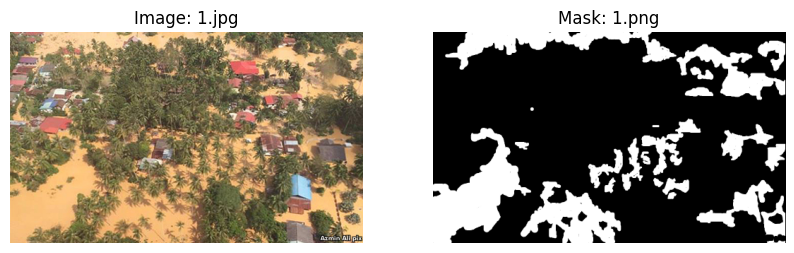

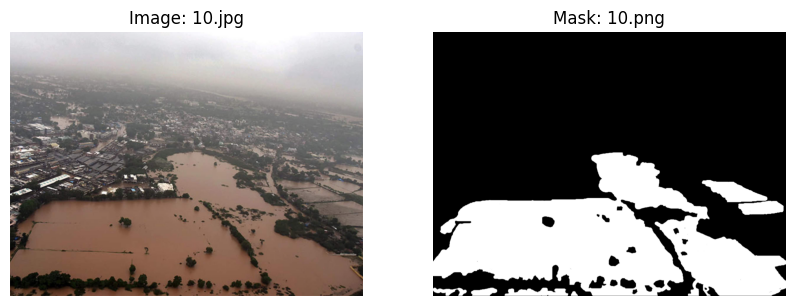

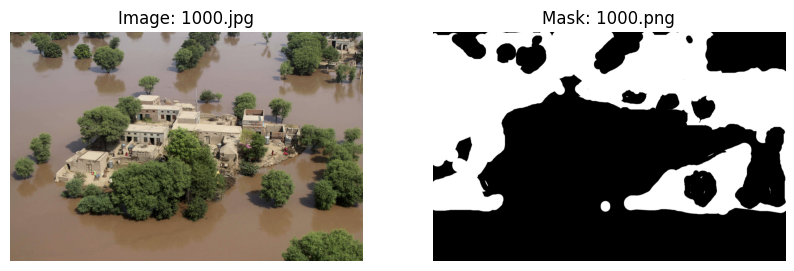

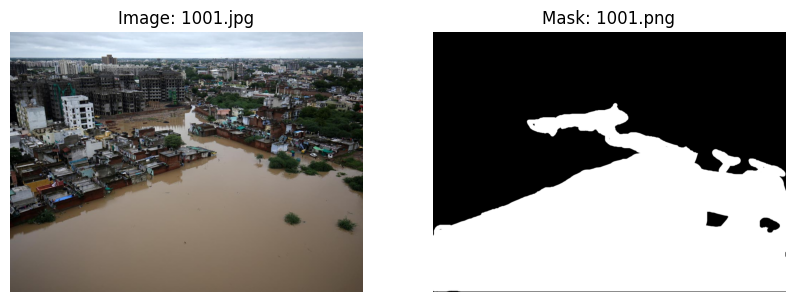

In [ ]:
def visualize_images_and_masks(num_images=5):
    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"Image: {img_file}")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Mask: {mask_file}")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.show()

# Call the function
visualize_images_and_masks()

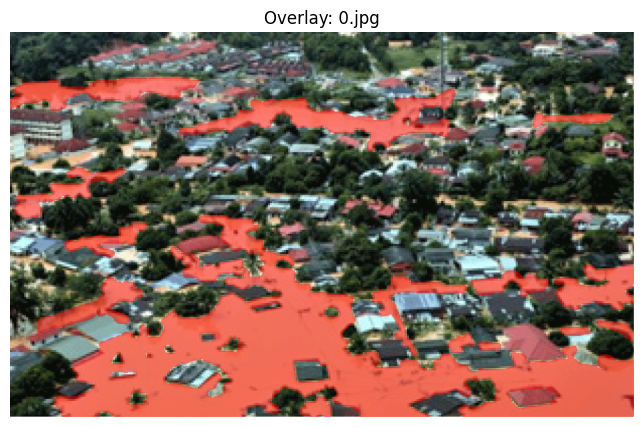

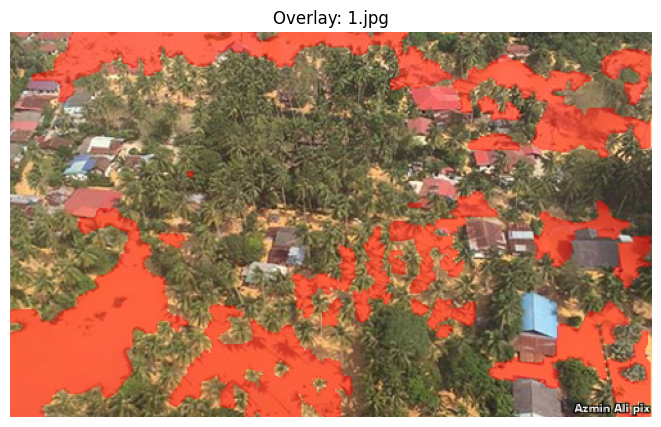

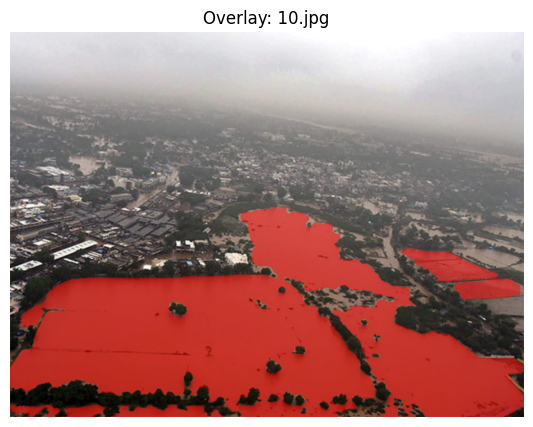

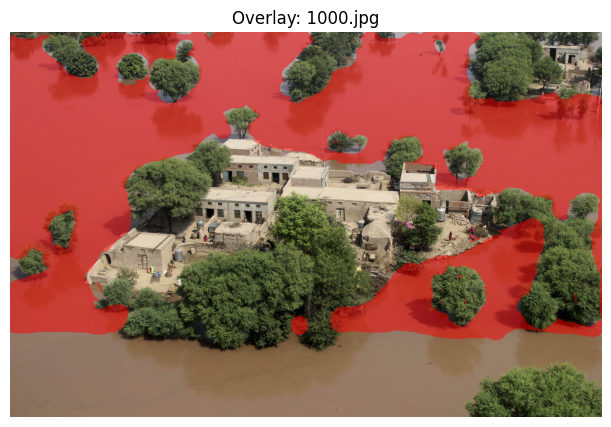

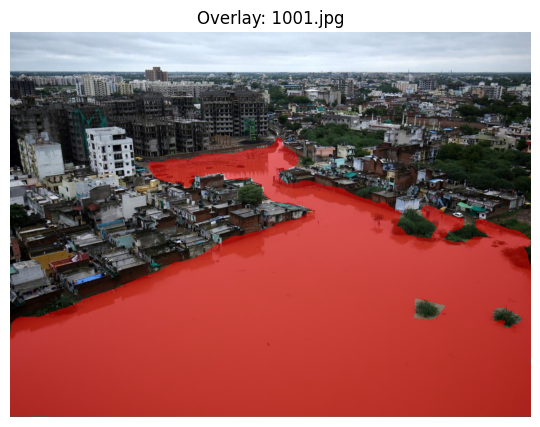

In [ ]:
def overlay_mask_on_image(num_images=5, alpha=0.5):
    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Convert to numpy arrays
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Create overlay by blending image and mask
        overlay = img_np.copy()
        overlay[mask_np > 0] = [255, 0, 0]  # Highlight mask area in red

        blended = (1 - alpha) * img_np + alpha * overlay
        blended = blended.astype(np.uint8)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.title(f"Overlay: {img_file}")
        plt.imshow(blended)
        plt.axis('off')
        plt.show()

# Call the function
overlay_mask_on_image()


## Processamento do Dataset

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

def load_images_and_masks():
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and resize
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
        mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")  # Grayscale

        # Normalize image and mask
        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

# Load dataset
images, masks = load_images_and_masks()
print(f"Loaded {len(images)} images and masks.")


Loaded 290 images and masks.


In [ ]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
X_train.shape,X_val.shape

((232, 224, 224, 3), (58, 224, 224, 3))

## Construção do Modelo

In [ ]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Create model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 112, 112,  │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

## Treinamento

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=BATCH_SIZE
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 124s 15s/step - accuracy: 0.5671 - loss: 0.6477 - val_accuracy: 0.7103 - val_loss: 0.5961
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 15s/step - accuracy: 0.6679 - loss: 0.5878 - val_accuracy: 0.7422 - val_loss: 0.5347
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 153s 17s/step - accuracy: 0.7407 - loss: 0.5276 - val_accuracy: 0.7647 - val_loss: 0.4784
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 132s 15s/step - accuracy: 0.7497 - loss: 0.5028 - val_accuracy: 0.7860 - val_loss: 0.4294
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 144s 16s/step - accuracy: 0.7674 - loss: 0.4613 - val_accuracy: 0.7497 - val_loss: 0.4873
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 15s/step - accuracy: 0.7440 - loss: 0.5023 - val_accuracy: 0.7881 - val_loss: 0.4176
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 131s 16s/step - accuracy: 0.7795 - loss: 0.4390 - val_accuracy: 0.7940 - val_loss: 0.4145
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 135s 15s/step - accuracy: 0.7768 - loss: 0.4328 - val_accuracy: 0.7794 - val_loss:

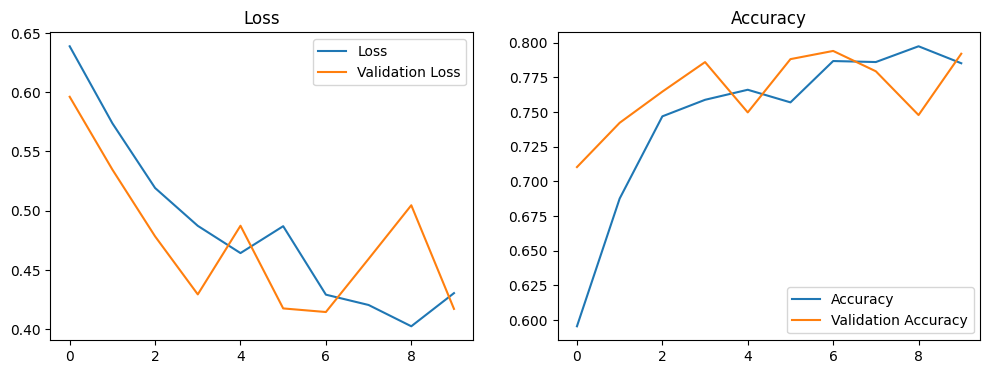

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()



## Inferência

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


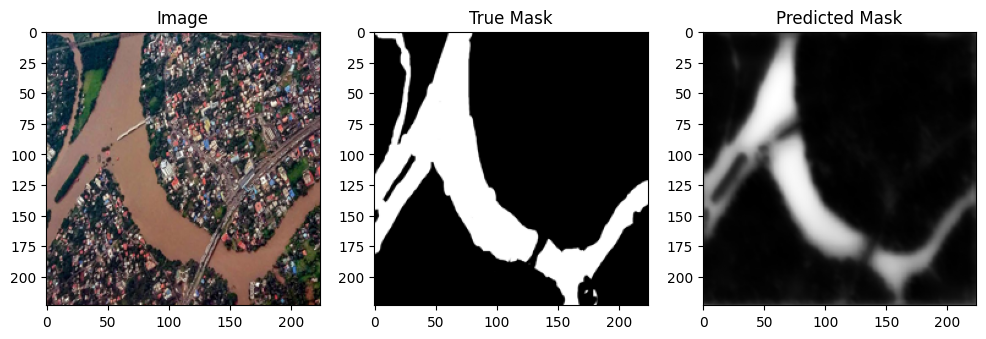

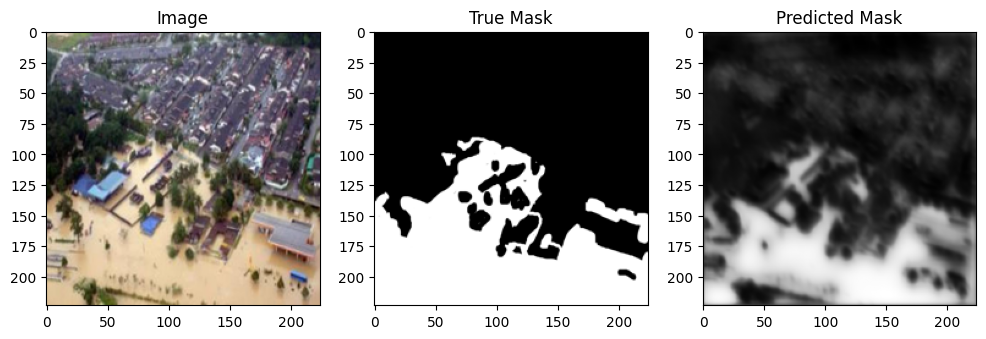

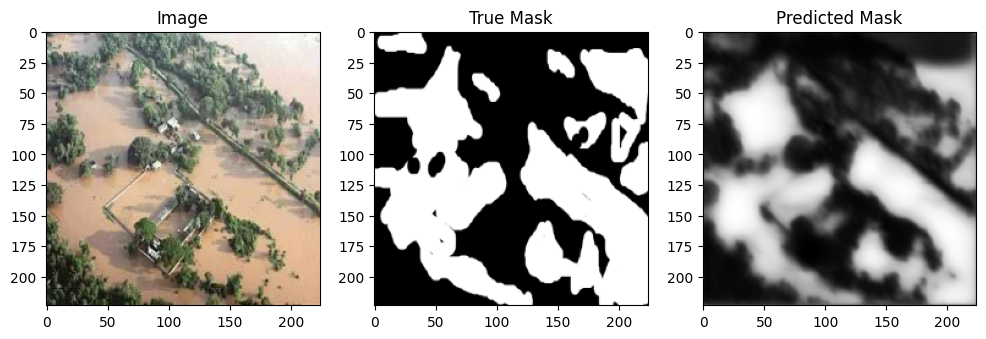

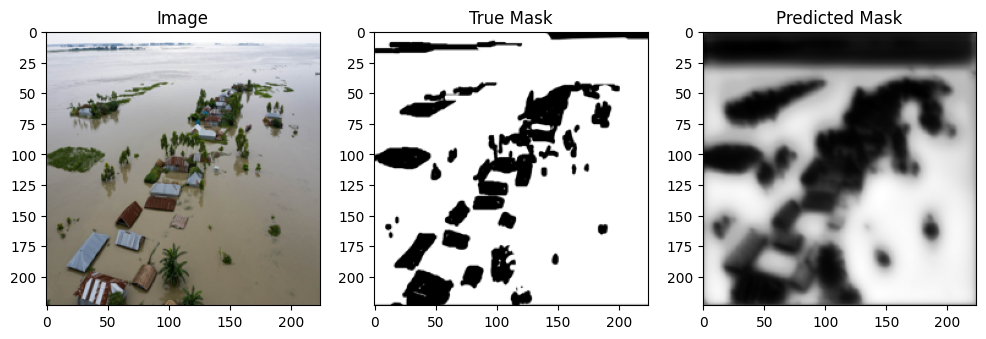

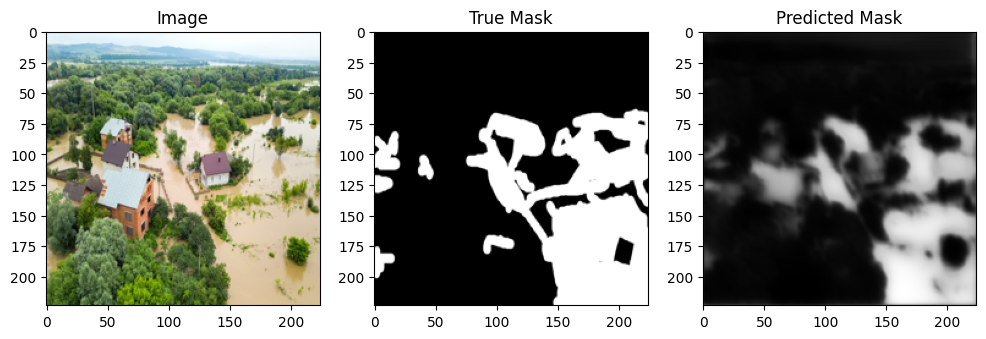

In [ ]:
# Visualize predictions
def visualize_predictions(num_images=5):
    preds = model.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_val[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')

        plt.show()

visualize_predictions()
